# Свертки в Keras

Будем использовать Fashion MNIST

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


In [3]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#GPU count and name
!nvidia-smi -L

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-3640a850-99c1-dc54-6fa7-580525d9e5af)


# Загрузим данные

Классы:
```
0 T-shirt/top 
1 Trouser 
2 Pullover 
3 Dress 
4 Coat 
5 Sandal 
6 Shirt 
7 Sneaker 
8 Bag 
9 Ankle boot
```




In [5]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


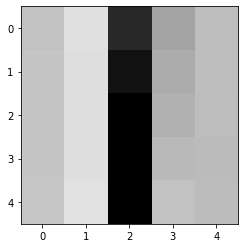

Пример картинки:


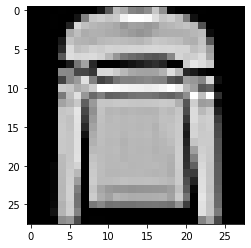

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [7]:
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

In [8]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Будем как и в предыдущем модуле минимизировать кросс-энтропию.

In [9]:
K.clear_session()

# в этот раз используем картинку как вход без вытягивания в вектор!

model = M.Sequential()
model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1))) # padding='same'
model.add(L.MaxPool2D())
model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(L.MaxPool2D())
model.add(L.Flatten())
model.add(L.Dense(64, activation='elu'))
model.add(L.Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [11]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [12]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(float) / 255 - 0.5
x_val_float = x_val.astype(float) / 255 - 0.5

In [13]:
print(x_train_float.shape)
print(x_train_float[:, :, :, np.newaxis].shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [14]:
model.fit(
    x_train_float[:, :, :, np.newaxis], 
    y_train_oh,
    batch_size=256, 
    epochs=10,
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)
)

Epoch 1/10


2022-07-25 20:38:49.876123: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-25 20:38:49.876612: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


235/235 [==============================] - 3s 3ms/step - loss: 0.6142 - accuracy: 0.7830 - val_loss: 0.4529 - val_accuracy: 0.8309
Epoch 2/10
235/235 [==============================] - 1s 2ms/step - loss: 0.3761 - accuracy: 0.8647 - val_loss: 0.3650 - val_accuracy: 0.8706
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.3245 - accuracy: 0.8822 - val_loss: 0.3460 - val_accuracy: 0.8769
Epoch 4/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2931 - accuracy: 0.8934 - val_loss: 0.3290 - val_accuracy: 0.8773
Epoch 5/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2727 - accuracy: 0.9014 - val_loss: 0.2941 - val_accuracy: 0.8975
Epoch 6/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2535 - accuracy: 0.9080 - val_loss: 0.2918 - val_accuracy: 0.8920
Epoch 7/10
235/235 [==============================] - 1s 2ms/step - loss: 0.2350 - accuracy: 0.9146 - val_loss: 0.2946 - val_accuracy: 0.8936
Epoch 8/10
235/23

In [15]:
# predicts = model.predict_classes(x_val_float[:, :, :, np.newaxis])
# print('Test Accuracy: ', accuracy_score(y_val, predicts))

predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 776us/step
Test Accuracy:  0.9047
